<h3>Dependencies

In [56]:
import sys, os

import numpy as np
import torch as T
from scipy.integrate import solve_ivp

from dataclasses import dataclass

from itertools import chain, combinations
from itertools import combinations_with_replacement as combinations_w_r

from sklearn.preprocessing import PolynomialFeatures

import torch_optimizer as optim_all

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

<h3> Models

In [2]:
def sdof_free_vibr(x, t):
    return [x[1], -0.1 * x[1] - x[0]]

def sdof_harmonic(x, t, forcing_freq=1.2):
    return [x[1], -0.1 * x[1] - x[0] + np.cos(forcing_freq * t)]

def sdof_friction(x, t, friction_force_ratio=0.5, forcing_freq=1.2):
    return [
        x[1],
        -0.1 * x[1]
        - x[0]
        - friction_force_ratio * np.sign(x[1])
        + np.cos(forcing_freq * t),
    ]

<h3> Coefficients dictionary

In [28]:
class coeffs_dictionary(T.nn.Module):
    def __init__(self, n_combinations):

        super(coeffs_dictionary, self).__init__()
        self.linear = T.nn.Linear(n_combinations, 1, bias=False)
        # Setting the weights to zeros
        self.linear.weight = T.nn.Parameter(0 * self.linear.weight.clone().detach())
    
    def forward(self, x):
        
        return self.linear(x)

In [57]:
class PolynomialLibrary(PolynomialFeatures):

    def __init__(
        self,
        degree=2,
        include_interaction=True,
        interaction_only=False,
        include_bias=True,
        order="C",
    ):
        super(PolynomialLibrary, self).__init__(
            degree=degree,
            interaction_only=interaction_only,
            include_bias=include_bias,
            order=order,
        )
        self.include_interaction = include_interaction

    @staticmethod
    def _combinations(
        n_features, degree, include_interaction, interaction_only, include_bias
    ):
        comb = combinations if interaction_only else combinations_w_r
        start = int(not include_bias)
        if not include_interaction:
            if include_bias:
                return chain(
                    [()],
                    chain.from_iterable(
                        combinations_w_r([j], i)
                        for i in range(1, degree + 1)
                        for j in range(n_features)
                    ),
                )
            else:
                return chain.from_iterable(
                    combinations_w_r([j], i)
                    for i in range(1, degree + 1)
                    for j in range(n_features)
                )
        return chain.from_iterable(
            comb(range(n_features), i) for i in range(start, degree + 1)
        )

    def fit(self, x, y=None):
        n_samples, n_features = x.shape
        combinations = self._combinations(
            n_features,
            self.degree,
            self.include_interaction,
            self.interaction_only,
            self.include_bias,
        )
        self.n_input_features_ = n_features
        self.n_output_features_ = sum(1 for _ in combinations)
        return self

    def transform(self, x):
        n_samples, n_features = x.shape

        combinations = self._combinations(
            n_features,
            self.degree,
            self.include_interaction,
            self.interaction_only,
            self.include_bias,
        )
        xp = np.empty(
            (n_samples, self.n_output_features_),
            dtype=x.dtype,
            order=self.order,
        )
        for i, comb in enumerate(combinations):
            xp[:, i] = x[:, comb].prod(1)

        return xp

    def transform_torch(self, x):
        n_samples, n_features = x.shape

        
        combinations = self._combinations(
            n_features,
            self.degree,
            self.include_interaction,
            self.interaction_only,
            self.include_bias,
        )
        
        xp = T.empty((n_samples, self.n_output_features_))
        for i, comb in enumerate(combinations):
            xp[:, i] = x[:, comb].prod(1)

        return xp


In [33]:
# ## Simple RK-SINDy model
# def rk4th_onestep_SparseId(x, library, LibsCoeffs, t=0, timestep=1e-2):

#     d1 = library.transform_torch(x)
#     k1 = T.column_stack((T.matmul(d1, T.tensor([0., 0., 1., 0., 0., 0.])).unsqueeze(1), LibsCoeffs(d1)))

#     xtemp = x + 0.5 * timestep * k1
#     d2 = library.transform_torch(xtemp)
#     k2 = T.column_stack((T.matmul(d2, T.tensor([0., 0., 1., 0., 0., 0.])).unsqueeze(1), LibsCoeffs(d2)))

#     xtemp = x + 0.5 * timestep * k2
#     d3 = library.transform_torch(xtemp)
#     k3 = T.column_stack((T.matmul(d3, T.tensor([0., 0., 1., 0., 0., 0.])).unsqueeze(1), LibsCoeffs(d3)))

#     xtemp = x + timestep * k3
#     d4 = library.transform_torch(xtemp)
#     k4 = T.column_stack((T.matmul(d4, T.tensor([0., 0., 1., 0., 0., 0.])).unsqueeze(1), LibsCoeffs(d4)))

#     return x + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * timestep

# ## Simple RK-SINDy model with forcing term
# def rk4th_onestep_SparseId_Force(x, library, LibsCoeffs, times, timestep=1e-2, forcing_freq=1.2):

#     d1 = library.transform_torch(x)
#     k1 = T.column_stack((T.matmul(d1, T.tensor([0., 0., 1., 0., 0., 0.])).unsqueeze(1), LibsCoeffs(d1) + T.cos(forcing_freq * times)))

#     d2 = library.transform_torch(x + 0.5 * timestep * k1)
#     k2 = T.column_stack((T.matmul(d2, T.tensor([0., 0., 1., 0., 0., 0.])).unsqueeze(1), LibsCoeffs(d2) + T.cos(forcing_freq * (times + 0.5 * timestep))))

#     d3 = library.transform_torch(x + 0.5 * timestep * k2)
#     k3 = T.column_stack((T.matmul(d3, T.tensor([0., 0., 1., 0., 0., 0.])).unsqueeze(1), LibsCoeffs(d3) + T.cos(forcing_freq * (times + 0.5 * timestep))))

#     d4 = library.transform_torch(x + 1.0 * timestep * k3)
#     k4 =  T.column_stack((T.matmul(d4, T.tensor([0., 0., 1., 0., 0., 0.])).unsqueeze(1), LibsCoeffs(d4) + T.cos(forcing_freq * (times + timestep))))

#     return x + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * timestep

In [64]:
## Generic RK-SINDy model
def rk4th_SparseId(x, library, LibsCoeffs, times, timesteps, Params, paramSize):

    first_eq_coeffs = T.zeros(size=(paramSize,))
    first_eq_coeffs[2] = 1.

    if Params.model == "free":
        d1 = library.transform_torch(x)
        k1 = T.column_stack(
            (
                T.matmul(d1, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d1)
            )
        )

        d2 = library.transform_torch(x + 0.5 * timesteps * k1)
        k2 = T.column_stack(
            (
                T.matmul(d2, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d2)
            )
        )

        d3 = library.transform_torch(x + 0.5 * timesteps * k2)
        k3 = T.column_stack(
            (
                T.matmul(d3, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d3)
            )
        )

        d4 = library.transform_torch(x + timesteps * k3)
        k4 = T.column_stack(
            (
                T.matmul(d4, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d4)
            )
        )

    elif Params.model == "forced":
        d1 = library.transform_torch(x)
        k1 = T.column_stack(
            (
                T.matmul(d1, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d1) 
                + T.cos(Params.forcing_freq * times)
            )
        )

        d2 = library.transform_torch(x + 0.5 * timesteps * k1)
        k2 = T.column_stack(
            (
                T.matmul(d2, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d2) 
                + T.cos(Params.forcing_freq * (times + 0.5 * timesteps))
            )
        )

        d3 = library.transform_torch(x + 0.5 * timesteps * k2)
        k3 = T.column_stack(
            (
                T.matmul(d3, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d3) 
                + T.cos(Params.forcing_freq * (times + 0.5 * timesteps))
            )
        )

        d4 = library.transform_torch(x + timesteps * k3)
        k4 = T.column_stack(
            (
                T.matmul(d4, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d4) 
                + T.cos(Params.forcing_freq * (times + timesteps))
            )
        )

    elif Params.model == "friction":
        d1 = library.transform_torch(x)
        k1 = T.column_stack(
            (
                T.matmul(d1, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d1) 
                -Params.friction_ratio * T.sign(x[:, 1]).unsqueeze(1) 
                + T.cos(Params.forcing_freq * times)
            )
        )

        xtemp = x + 0.5 * timesteps * k1
        d2 = library.transform_torch(xtemp)
        k2 = T.column_stack(
            (
                T.matmul(d2, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d2) 
                -Params.friction_ratio * T.sign(xtemp[:, 1]).unsqueeze(1) 
                + T.cos(Params.forcing_freq * (times + 0.5 * timesteps))
            )
        )

        xtemp = x + 0.5 * timesteps * k2
        d3 = library.transform_torch(xtemp)
        k3 = T.column_stack(
            (
                T.matmul(d3, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d3) 
                -Params.friction_ratio * T.sign(xtemp[:, 1]).unsqueeze(1) 
                + T.cos(Params.forcing_freq * (times + 0.5 * timesteps))
            )
        )

        xtemp = x + timesteps * k3
        d4 = library.transform_torch(xtemp)
        k4 = T.column_stack(
            (
                T.matmul(d4, first_eq_coeffs).unsqueeze(1), 
                LibsCoeffs(d4) 
                -Params.friction_ratio * T.sign(xtemp[:, 1]).unsqueeze(1) 
                + T.cos(Params.forcing_freq * (times + timesteps))
            )
        )

    return x + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * timesteps

In [65]:
def learning_sparse_model(dictionary, Coeffs, train_set, times, Params, paramSize, lr_reduction=10, quite=False):

    # Define optimizer
    opt_func = optim_all.RAdam(
        Coeffs.parameters(), lr=Params.lr, weight_decay=Params.weightdecay
    )
    # Define loss function
    criteria = T.nn.MSELoss()
    # pre-allocate memory for loss_fuction
    loss_track = np.zeros((Params.num_iter, Params.num_epochs))
    #########################
    ###### Training #########
    #########################
    for p in range(Params.num_iter):
        for g in range(Params.num_epochs):
            Coeffs.train()

            opt_func.zero_grad()

            loss_new = T.autograd.Variable(T.tensor([0.0], requires_grad=True))
            weights = 2 ** (-0.5 * T.linspace(0, 0, 1))

            timesteps_i = T.tensor(np.diff(times, axis=0)).float()
            y_total = train_set

            ##################################
            # One forward step predictions
            ##################################

            y_pred = rk4th_SparseId(
                y_total[:-1],
                dictionary,
                Coeffs,
                times[:-1],
                timesteps=timesteps_i,
                Params=Params,
                paramSize=paramSize
            )

            ##################################
            # One backward step predictions
            ##################################
            y_pred_back = rk4th_SparseId(
                y_total[1:],
                dictionary,
                Coeffs,
                times[1:],
                timesteps=-timesteps_i,
                Params=Params,
                paramSize=paramSize
            )

            loss_new += criteria(y_pred, y_total[1:]) + weights[0] * criteria(
                y_pred_back, y_total[:-1]
            )

            # loss_new /= y[0].shape[0]
            loss_track[p, g] += loss_new.item()
            loss_new.backward()
            opt_func.step()

            sys.stdout.write(
                "\r [Iter %d/%d] [Epoch %d/%d] [Training loss: %.2e] [Learning rate: %.2e]"
                % (
                    p + 1,
                    Params.num_iter,
                    g + 1,
                    Params.num_epochs,
                    loss_track[p, g],
                    opt_func.param_groups[0]["lr"],
                )
            )

        # Removing the coefficients smaller than tol and set gradients w.r.t. them to zero
        # so that they will not be updated in the iterations
        Ws = Coeffs.linear.weight.detach().clone()
        Mask_Ws = (Ws.abs() > Params.tol_coeffs).type(T.float)
        Coeffs.linear.weight = T.nn.Parameter(Ws * Mask_Ws)

        if not quite:
            print("\n")
            print(Ws)
            print(
                "\nError in coeffs due to truncation: {}".format(
                    (Ws - Coeffs.linear.weight).abs().max()
                )
            )
            print("Printing coeffs after {} iter after truncation".format(p + 1))
            print(Coeffs.linear.weight)
            print("\n" + "=" * 50)

        Coeffs.linear.weight.register_hook(lambda grad: grad.mul_(Mask_Ws))
        new_lr = opt_func.param_groups[0]["lr"] / lr_reduction
        opt_func = optim_all.RAdam(
            Coeffs.parameters(), lr=new_lr, weight_decay=Params.weightdecay
        )

    return Coeffs, loss_track

In [66]:
randSeed = 42

T.manual_seed(randSeed)
np.random.seed(seed=randSeed)

In [67]:
@dataclass
class parameters:
    bs: int = 1
    num_epochs: int = 1000
    num_iter = 3
    lr: float = 1e-2
    # save_model_path: str = "./Results/SDOF_free_vibration/"
    save_model_path: str = "./Results/Refactored/"
    weightdecay: float = 0.0
    NumInitial: int = 1
    dim_x: int = 2
    timefinal: float = 50.0
    timestep: float = 1e-1
    normalize: bool = False
    tol_coeffs: float = 5e-2
    poly_order: int = 2
    tikz_save: bool = False
    noise_level: float = 1e-2
    model: str = "friction" # "free", "forced", "friction"
    forcing_freq: float = 1.2
    friction_ratio: float = 0.2
    
Params = parameters()

os.makedirs(os.path.dirname(Params.save_model_path), exist_ok=True)

In [68]:
ts = np.arange(0, Params.timefinal, Params.timestep)
ts = np.sort(np.random.choice(ts, size=(200,), replace=False))

# Initial condition and simulation time
x0 = [0.1, 0.1]

# Solve the equation
if Params.model == "free":
    sol = solve_ivp(lambda t, x: sdof_free_vibr(x, t), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)
elif Params.model == "forced":
    sol = solve_ivp(lambda t, x: sdof_harmonic(x, t, Params.forcing_freq), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)
elif Params.model == "friction":
    sol = solve_ivp(lambda t, x: sdof_friction(x, t, Params.friction_ratio, Params.forcing_freq), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)

x = np.transpose(sol.y)

# Generate noisy measurements
x = np.random.normal(loc=x, scale=Params.noise_level * np.abs(x), size=x.shape)

In [69]:
# Define dataloaders
train_dset = T.tensor(x).float()
times = T.tensor(ts).unsqueeze(1).float()

# defining library
funs_dictionary = PolynomialLibrary(degree=Params.poly_order)
funs_dictionary.fit(x)
funs_dictionary_size = funs_dictionary.transform(x).shape[1]

Coeffs = coeffs_dictionary(funs_dictionary_size)

# Learning Coefficients
Coeffs, loss_track = learning_sparse_model(funs_dictionary, Coeffs, train_dset, times, Params, paramSize=funs_dictionary_size, quite=True)
# Coeffs, loss_track = learning_sparse_model(funs_dictionary, Coeffs, train_dset, times, Params, quite=True)
Learned_Coeffs = Coeffs.linear.weight.detach().clone().t().numpy()

 [Iter 2/3] [Epoch 70/1000] [Training loss: 1.22e-03] [Learning rate: 1.00e-03]2]

In [54]:
Learned_Coeffs = np.column_stack(([0., 0., 1., 0., 0., 0.], Learned_Coeffs))
Learned_Coeffs

array([[ 0.        , -0.        ],
       [ 0.        , -1.00071871],
       [ 1.        , -0.09761214],
       [ 0.        , -0.        ],
       [ 0.        , -0.        ],
       [ 0.        , -0.        ]])

In [41]:
ts_refine = np.arange(0, Params.timefinal, 1e-2)

# Solve the equation
if Params.model == "free":
    learnt_deri = lambda t, z: (funs_dictionary.transform(np.expand_dims(z, axis=0)) @ Learned_Coeffs).squeeze(0)
    sol = solve_ivp(lambda t, x: sdof_free_vibr(x, t), t_span=[ts_refine[0], ts_refine[-1]], y0=x0, t_eval=ts_refine)
elif Params.model == "forced":
    learnt_deri = lambda t, z: (funs_dictionary.transform(np.expand_dims(z, axis=0)) @ Learned_Coeffs).squeeze(0) + np.array([0, np.cos(Params.forcing_freq * t)])
    sol = solve_ivp(lambda t, x: sdof_harmonic(x, t, Params.forcing_freq), t_span=[ts_refine[0], ts_refine[-1]], y0=x0, t_eval=ts_refine)
elif Params.model == "friction":
    learnt_deri = lambda t, z: (funs_dictionary.transform(np.expand_dims(z, axis=0)) @ Learned_Coeffs).squeeze(0) + np.array([0, - Params.friction_ratio * np.sign(z[1]) + np.cos(Params.forcing_freq * t)])
    sol = solve_ivp(lambda t, x: sdof_friction(x, t, Params.friction_ratio, Params.forcing_freq), t_span=[ts_refine[0], ts_refine[-1]], y0=x0, t_eval=ts_refine)

x_refine = np.transpose(sol.y)

sol_learnt = solve_ivp(learnt_deri, [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine,)
x_learnt = np.transpose(sol_learnt.y)

<h3>Plotting

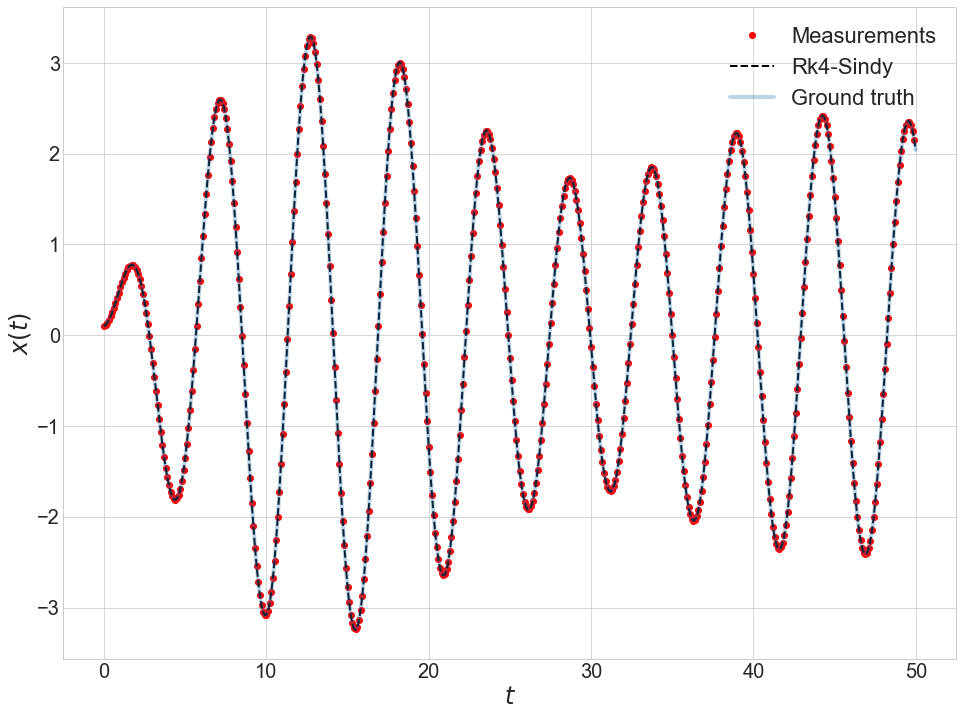

In [42]:
plt.figure(figsize=(16,12))

plt.plot(ts, x[:, 0], "ro", markersize=6, label="Measurements")
plt.plot(ts_refine, x_learnt[:, 0], "k--", linewidth=2, label="Rk4-Sindy")
plt.plot(ts_refine, x_refine[:, 0], alpha=0.3, linewidth=4, label="Ground truth")

plt.legend(fontsize=22)#, bbox_to_anchor=(1.1, 1.05))#, loc='upper right')
plt.xlabel("$t$", fontsize=24)
plt.ylabel("$x(t)$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

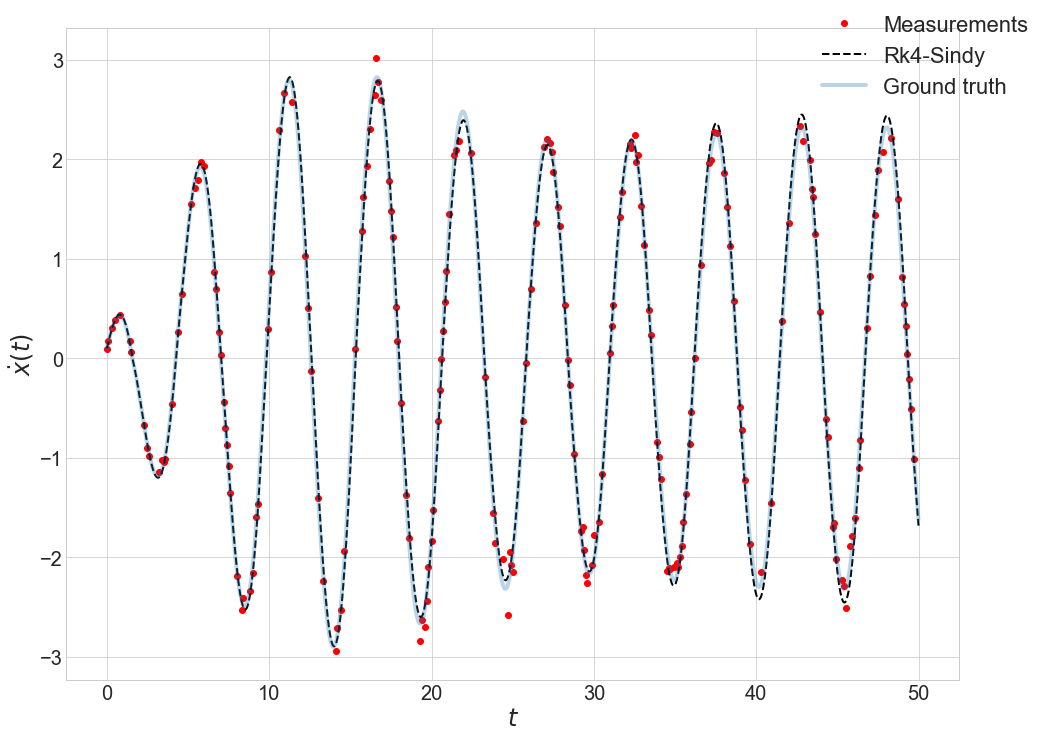

In [38]:
plt.figure(figsize=(16,12))

plt.plot(filtered_ts, x[:, 1], "ro", markersize=6, label="Measurements")
plt.plot(ts_refine, x_learnt[:, 1], "k--", linewidth=2, label="Rk4-Sindy")
plt.plot(ts_refine, x_refine[:, 1], alpha=0.3, linewidth=4, label="Ground truth")

plt.legend(fontsize=22, bbox_to_anchor=(1.1, 1.05))
plt.xlabel("$t$", fontsize=24)
plt.ylabel("$\dot{x}(t)$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

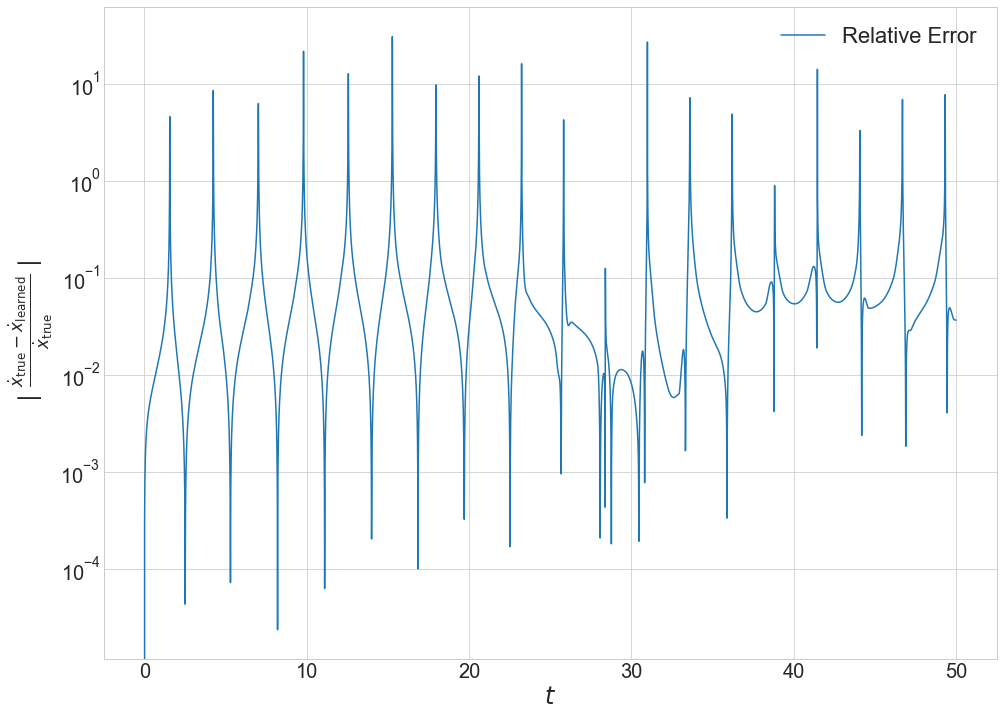

In [80]:
ind = 1

relError = np.abs((x_refine[:, ind] - x_learnt[:, ind]) / x_refine[:, ind])
squaredError = (x_refine[:, ind] - x_learnt[:, ind]) ** 2

plt.figure(figsize=(16,12))

plt.plot(ts_refine, relError, label='Relative Error')
# plt.plot(ts_refine, squaredError)


plt.yscale("log")

plt.legend(fontsize=22)#, bbox_to_anchor=(1.1, 1.05))

plt.xlabel("$t$", fontsize=24)
# plt.ylabel(r"$\mid \frac{x_{\mathrm{true}} - x_{\mathrm{learned}}}{x_{\mathrm{true}}} \mid$", fontsize=24)
plt.ylabel(r"$\mid \frac{\dot{x}_{\mathrm{true}} - \dot{x}_{\mathrm{learned}}}{\dot{x}_{\mathrm{true}}} \mid$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()


<h4> Logging

In [14]:
with closing(
    Tee(
        # f"{Params.save_model_path}Noisy_SDOF_free_vibration.log",
        # f"{Params.save_model_path}Noisy_SDOF_harmonic_excitation.log",
        f"{Params.save_model_path}Noisy_SDOF_Friction.log",
        "a+",
        channel="stdout",
    )
) as outputstream:
    # printing of the learned sparse models in a file
    print(f"{'='*50}\nRK4 Inspired Methods Sparse Identification")
    printing_learned_model(Learned_Coeffs, funs_dictionary.get_feature_names())
    # print(f"{'='*50}\nSindy Approach")
    # model.print()
    print(f"{'='*50}\n{'*'*100}")


RK4 Inspired Methods Sparse Identification
dx0'= 0.745 x1 + 0.172 x0 x1 
dx1'= -0.991 x0 + -0.115 x0^2 + -0.151 x0 x1 
****************************************************************************************************


(100,)